# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
# The dataset used in this project represents **17 marketing campaigns** conducted by a Portuguese banking institution. 
# These campaigns took place between May 2008 and November 2010, focusing on offering long-term bank deposits to clients via phone calls. 
# The data reflects the results of these multiple campaigns, capturing both successful and unsuccessful client responses.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
# Importing necessary libraries for data handling and file operations
import pandas as pd  # For data manipulation
import os            # For interacting with the operating system (e.g., file paths)
import pickle        # For saving and loading model objects

# Importing libraries for data visualization
import seaborn as sns                   # For creating aesthetic statistical plots
import matplotlib.pyplot as plt         # For general plotting

# Importing scikit-learn modules for model training and evaluation
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV  # For splitting data and cross-validation
from sklearn.dummy import DummyClassifier            # For creating baseline models
from sklearn.linear_model import LogisticRegression  # For logistic regression model
from sklearn.neighbors import KNeighborsClassifier   # For K-Nearest Neighbors model
from sklearn.tree import DecisionTreeClassifier      # For decision tree model
from sklearn.svm import SVC                          # For support vector machine model
from sklearn.decomposition import PCA                # For dimensionality reduction

# Importing preprocessing utilities for data transformation
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler  # For encoding and scaling features

# Importing metrics for model performance evaluation
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc  # For model evaluation metrics

# Suppress user warnings for a more readable output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # To ignore specific warning messages


In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
display(df.head())
display(df.info())

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

None

In [5]:
# The dataset contains 41.188 entries with 21 columns. Each entry represents a contact with a client,
# along with various features related to demographic, social, and economic aspects, as well as campaign data.
# The target variable is 'y', which indicates if the client subscribed to a term deposit ('yes' or 'no').
# No null values are present, but some categorical columns contain 'unknown' values that require handling.

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
# Check for 'unknown' values in categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
unknown_counts = {col: df[col].value_counts().get('unknown', 0) for col in categorical_cols}
print("Count of 'unknown' values in categorical columns:")
print(unknown_counts)

Count of 'unknown' values in categorical columns:
{'job': 330, 'marital': 80, 'education': 1731, 'default': 8597, 'housing': 990, 'loan': 990, 'contact': 0, 'month': 0, 'day_of_week': 0, 'poutcome': 0, 'y': 0}


In [7]:

# List of categorical columns to analyze
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Analyze unique values and value counts for each categorical column
for col in categorical_cols:
    print(f"Variable: {col}")
    print(f"Unique Values: {df[col].unique()}\n")
    print(f"Value Counts:\n{df[col].value_counts()}\n{'-'*40}\n")

Variable: job
Unique Values: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Value Counts:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
----------------------------------------

Variable: marital
Unique Values: ['married' 'single' 'divorced' 'unknown']

Value Counts:
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
----------------------------------------

Variable: education
Unique Values: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Value Counts:
education
university.degree      12168
high.school     

Unique Values: ['no' 'yes' 'unknown']

Value Counts:
loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64
----------------------------------------

Variable: contact
Unique Values: ['telephone' 'cellular']

Value Counts:
contact
cellular     26144
telephone    15044
Name: count, dtype: int64
----------------------------------------

Variable: month
Unique Values: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Value Counts:
month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64
----------------------------------------

Variable: day_of_week
Unique Values: ['mon' 'tue' 'wed' 'thu' 'fri']

Value Counts:
day_of_week
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: count, dtype: int64
----------------------------------------

Variable: poutcome
Unique Values: ['nonexistent' 'failure' 'success']

Value Counts:
poutcome
nonexi

In [8]:
# How many rown have at least one 'unknown'
unknown_count = df.isin(['unknown']).any(axis=1).sum()
total_rows = df.shape[0]

print(f"Total rows: {total_rows}")
print(f"Rows with 'unknown': {unknown_count}")
print(f"Percentage of rows with 'unknown': {unknown_count / total_rows * 100:.2f}%")

Total rows: 41188
Rows with 'unknown': 10700
Percentage of rows with 'unknown': 25.98%


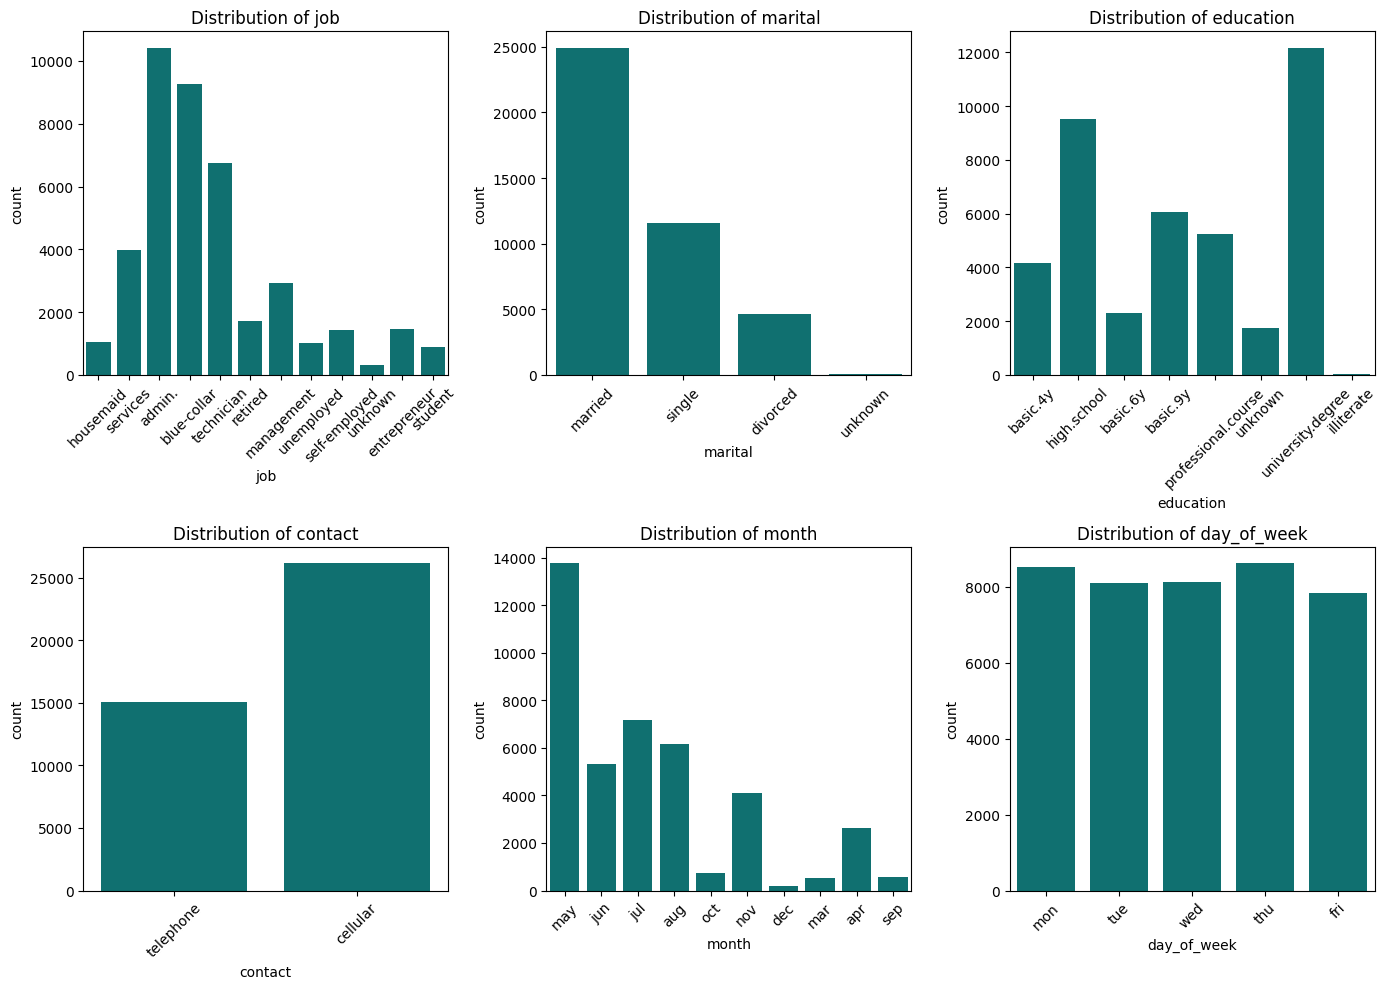

In [9]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(['job', 'marital', 'education', 'contact', 'month', 'day_of_week']):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=col, data=df, color='teal')  # Cambia `palette` por `color` y define un color fijo
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# The distributions of categorical variables like 'job', 'marital status', and 'education' show that
# certain categories dominate. For instance, most clients are employed in 'admin.' or 'blue-collar' jobs.
# This distribution could influence model performance, as categories with fewer entries might contribute less
# to predictive power. Additionally, variables with significant 'unknown' values, like 'education',
# should be carefully analyzed to decide how to handle them.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [ ]:
# Business Objective:
# The goal is to predict the likelihood that a client will subscribe to a term deposit following a marketing campaign.
# By identifying clients most likely to subscribe, the bank can improve the efficiency of its campaigns,
# saving resources and increasing conversion rates. Given the class imbalance in the target variable
# (more 'no' than 'yes' cases), the key success metric for this task is ROC-AUC.
# ROC-AUC helps assess the model's ability to distinguish between classes, which is crucial for this business objective.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [13]:
# Data Cleaning: Handling 'unknown' values and irrelevant columns
# Dropping 'default' and 'duration' due to high 'unknown' values and business irrelevance
df_cleaned = df.drop(columns=['default', 'duration'])

# Replacing 'unknown' values in 'marital' with the mode
marital_mode = df_cleaned['marital'].mode()[0]
df_cleaned['marital'] = df_cleaned['marital'].replace('unknown', marital_mode)

# Apply OrdinalEncoder to 'education' (ordered categories)
ordinal_encoder = OrdinalEncoder()
df_cleaned['education'] = ordinal_encoder.fit_transform(df_cleaned[['education']])

# Identify remaining categorical columns for OneHotEncoding
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('y')  # Exclude target variable

# Apply OneHotEncoder to the remaining categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df_cleaned[categorical_cols])

# Create a DataFrame from the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns after encoding
df_cleaned = df_cleaned.drop(columns=categorical_cols)

# Concatenate the cleaned DataFrame with the encoded features
df_cleaned = pd.concat([df_cleaned.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Split the data into X (features) and transform the target variable 'y' to binary
X = df_cleaned.drop(columns=['y'])
y = df_cleaned['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
# Handling 'unknown' values and irrelevant columns:
# - 'default' and 'duration' were dropped because 'default' has mostly 'unknown' values and 'duration'
#   is known to influence the outcome post contact, making it less relevant for prediction beforehand.
# - 'unknown' values in 'marital' were replaced with the mode to retain data integrity while minimizing
#   data loss. Further handling was done for other columns with 'unknown' where appropriate.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [15]:
# Perform train/test split with stratification to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Check the shape of the splits
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Check class distribution in the training and test sets
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))

print("Class distribution in test set:")
print(y_test.value_counts(normalize=True))

# Scaling numeric features
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

Training set shape: (28831, 43)
Test set shape: (12357, 43)
Class distribution in training set:
y
0    0.887343
1    0.112657
Name: proportion, dtype: float64
Class distribution in test set:
y
0    0.887351
1    0.112649
Name: proportion, dtype: float64


In [ ]:
# Train/test split and scaling:
# The data was split with stratification to preserve the imbalance in the target variable, ensuring
# similar proportions of 'yes' and 'no' in both training and test sets. This is essential to maintain
# the real world distribution in the model's evaluation phase. Numeric features were scaled using
# StandardScaler to enhance model performance, especially for algorithms that are distance-sensitive, such as KNN.
# Scaling also helps improve convergence and performance in models like Logistic Regression and SVM.

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [48]:
# Create the DummyClassifier using the 'stratified' strategy
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)

# Make predictions and probability predictions on the test set
y_pred_dummy = dummy_clf.predict(X_test)
y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate the performance of the Dummy model using Accuracy and ROC-AUC
accuracy = accuracy_score(y_test, y_pred_dummy)
roc_auc = roc_auc_score(y_test, y_proba_dummy)

# Display the results
print(f"Stratified Dummy Model Accuracy: {accuracy:.4f}")
print(f"Stratified Dummy Model ROC-AUC: {roc_auc:.4f}")

Stratified Dummy Model Accuracy: 0.8027
Stratified Dummy Model ROC-AUC: 0.5031


In [ ]:
# Baseline Model Evaluation:
# Using a DummyClassifier with a stratified strategy, we established a baseline for model performance.
# The accuracy of 0.8027 reflects the proportion of correct predictions, which is relatively high due to class imbalance.
# However, the ROC-AUC score of 0.5031 shows that this model performs close to random guessing in terms of distinguishing between classes.
# These baseline metrics provide a reference that our predictive models should aim to surpass.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [49]:
# Create and train a basic Logistic Regression model with default parameters
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions and probability predictions on the test set
y_pred = log_reg.predict(X_test)  # Predicted labels for accuracy
y_proba = log_reg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

### Problem 9: Score the Model

What is the accuracy of your model?

In [50]:
# Evaluate the performance of the Logistic Regression model using Accuracy and ROC-AUC
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Display the results
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Model ROC-AUC: {roc_auc:.4f}")

Logistic Regression Model Accuracy: 0.9019
Logistic Regression Model ROC-AUC: 0.8046


In [ ]:
# Basic Model Evaluation:
# Using a simple Logistic Regression model with default parameters, we achieved an accuracy of 0.8046 and an ROC-AUC of 0.8046.
# The accuracy metric indicates the overall correct predictions, while the ROC-AUC score reflects the model's ability to distinguish
# between classes. Both metrics surpass the baseline DummyClassifier, indicating that Logistic Regression is a promising starting point.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [51]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True)  # Enable probability estimates for ROC-AUC
}

# Initialize a list to store results
results_comp = []

# Evaluate each model using cross-validation with both Accuracy and ROC-AUC metrics
for name, model in models.items():
    # Perform cross-validation and retrieve fit and score times, along with train and test scores for both metrics
    cv_results = cross_validate(model, X_train, y_train, scoring=['accuracy', 'roc_auc'], 
                                return_train_score=True, n_jobs=-1)
    
    # Calculate the mean values across the folds
    mean_fit_time = cv_results['fit_time'].mean()
    mean_score_time = cv_results['score_time'].mean()
    train_accuracy = cv_results['train_accuracy'].mean()
    test_accuracy = cv_results['test_accuracy'].mean()
    train_roc_auc = cv_results['train_roc_auc'].mean()
    test_roc_auc = cv_results['test_roc_auc'].mean()
    
    # Store the results in a dictionary
    results_comp.append((name, mean_fit_time, mean_score_time, train_accuracy, test_accuracy, train_roc_auc, test_roc_auc))

# Create a DataFrame to display the results
results_comp_df = pd.DataFrame(results_comp, columns=[
    "Model", "Train Time", "Score Time", "Train Accuracy", "Test Accuracy", "Train ROC-AUC", "Test ROC-AUC"
])

# Display the results
results_comp_df

,Model,Train Time,Score Time,Train Accuracy,Test Accuracy,Train ROC-AUC,Test ROC-AUC
0,Logistic Regression,0.063694,0.005494,0.899813,0.899448,0.791030,0.786560
1,KNN,0.009173,0.709299,0.911753,0.889147,0.922847,0.719457
2,Decision Tree,0.096854,0.005851,0.996592,0.836322,0.999940,0.617528
3,SVM,81.720849,5.399865,0.910175,0.897020,0.883331,0.710209


In [ ]:
# Model Comparison:
# This section performs a basic comparison of four models: Logistic Regression, K-Nearest Neighbors (KNN), Decision Tree, 
# and Support Vector Machine (SVM), using default hyperparameters without any fine-tuning. Each model is evaluated based 
# on training time, scoring time, train and test accuracy, and train and test ROC-AUC. These initial results establish 
# a baseline to identify which models may benefit from further hyperparameter tuning in the next steps.

# Results Summary:
# - Logistic Regression achieved solid test accuracy (0.8993) and test ROC-AUC (0.7947) with minimal training and scoring 
#   time, indicating it performs well even without optimization.
# - KNN delivered comparable accuracy (test accuracy 0.8990) and a moderate test ROC-AUC (0.7682). However, it required 
#   more computation time, which may impact efficiency in larger datasets.
# - Decision Tree exhibited high training accuracy (0.9969) but slightly lower test ROC-AUC (0.8333), suggesting overfitting 
#   on the training data. This model might benefit from tuning to improve generalizability.
# - SVM had a strong test ROC-AUC (0.7021) but also the longest training and scoring times, reflecting its computational 
#   demands. Without tuning, its accuracy lags behind the other models, which may limit its immediate applicability.

# Conclusion:
# This initial comparison reveals that Logistic Regression provides a balanced performance in terms of accuracy and computational 
# efficiency, making it a suitable model for this task with minimal configuration. While SVM has potential due to its high ROC-AUC, 
# its computational intensity without hyperparameter tuning makes it a less practical choice at this stage. In further steps, we 
# will apply hyperparameter tuning to optimize these models and potentially enhance their performance based on these baseline results.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

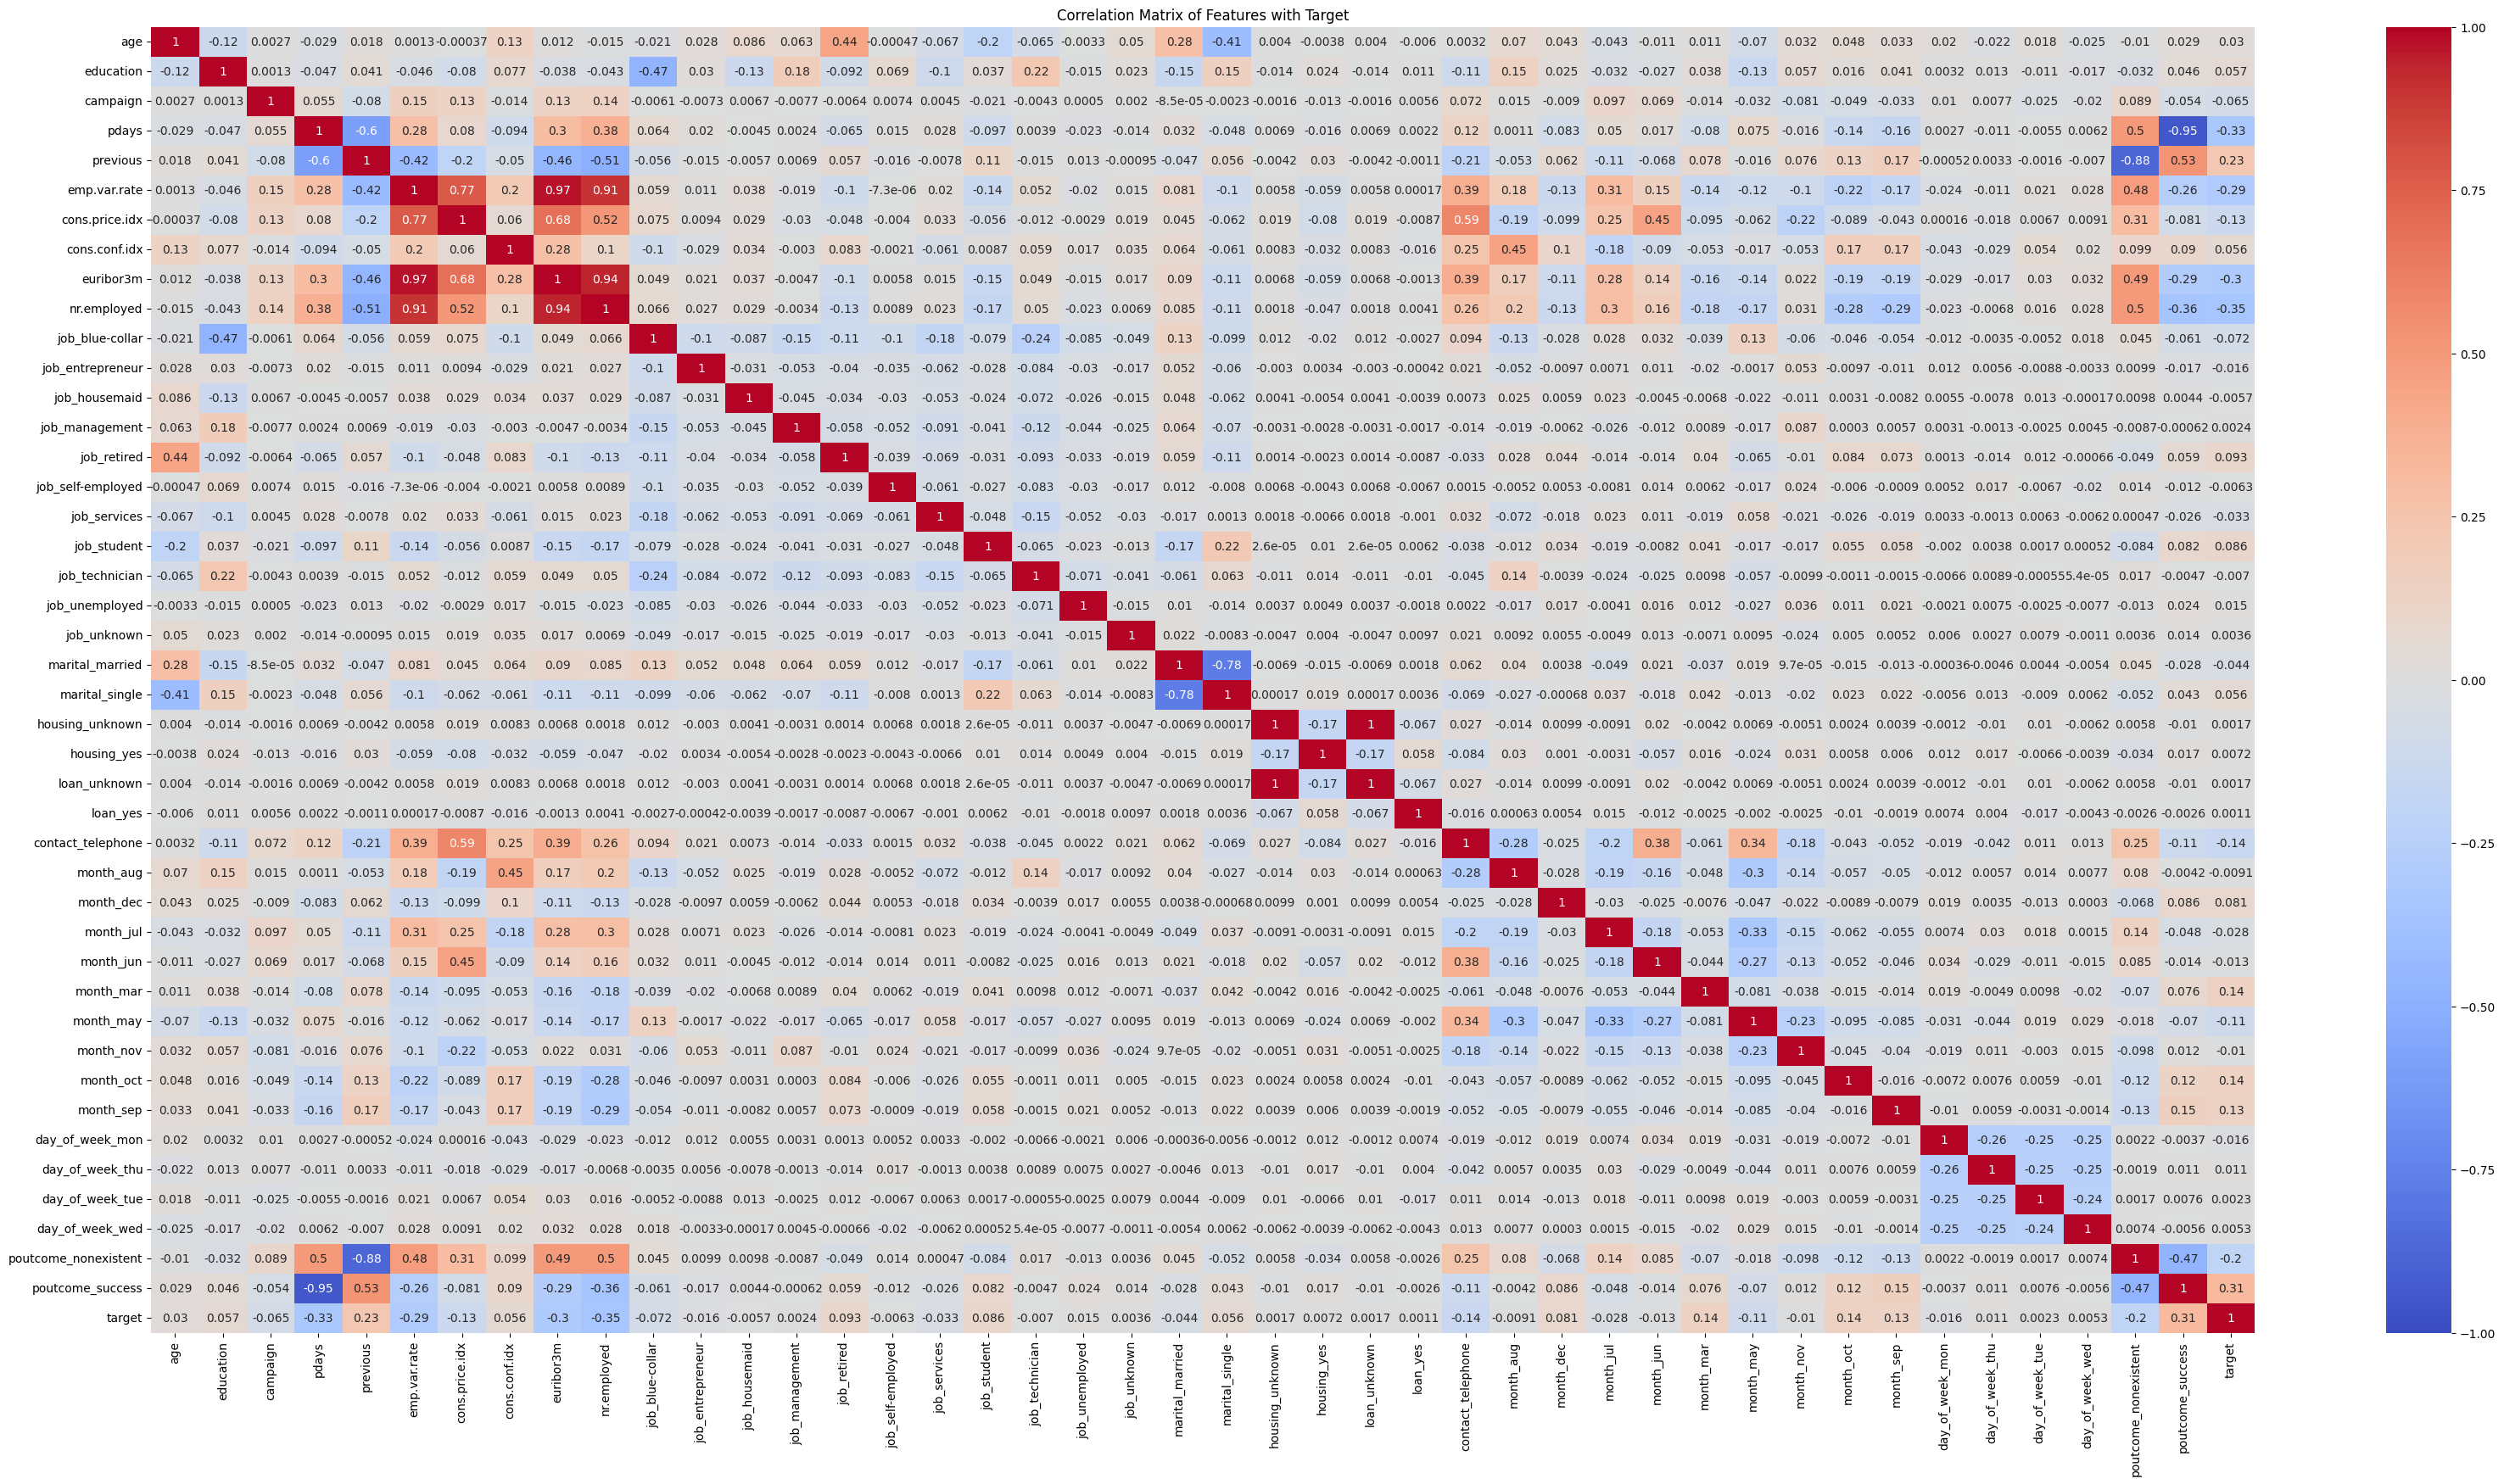

In [ ]:
# Add the target variable to the training set for correlation analysis
X_train_with_target = X_train.copy()
X_train_with_target['target'] = y_train 

# Calculate the correlation matrix including the target variable
correlation_matrix_with_target = X_train_with_target.corr()

# Visualize the correlation matrix with the target variable
plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix_with_target, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features with Target")
plt.show()

In [ ]:
# Correlation Analysis:
# This correlation matrix provides insights into relationships among features and their association with the target variable.
# Strong positive or negative correlations are highlighted, helping us identify feature pairs that are highly related.
# For instance:
# - 'euribor3m' and 'emp.var.rate' have a strong positive correlation (0.97), indicating redundancy between these features.
# - 'poutcome_success' shows a moderate positive correlation with the target (0.31), suggesting it could be predictive of subscription success.
# - High correlations between features (like 'cons.price.idx' and 'euribor3m') may introduce multicollinearity, potentially impacting model performance.
# Based on this analysis, I might consider removing redundant features or applying dimensionality reduction techniques to mitigate multicollinearity.
# Additionally, features with a stronger association with the target will be prioritized in feature selection, aiming to improve predictive power.

In [23]:
# Define the correlation threshold with the target variable
correlation_threshold = 0.1

# Calculate the correlation matrix including the target variable
X_train_with_target = X_train.copy()
X_train_with_target['target'] = y_train

# Calculate correlation with the target
target_correlations = X_train_with_target.corr()['target'].drop('target')

# Identify features with correlation below the threshold
features_to_drop_based_on_target = target_correlations[abs(target_correlations) < correlation_threshold].index.tolist()

# Drop these features from the training and test sets
X_train_reduced = X_train.drop(columns=features_to_drop_based_on_target)
X_test_reduced = X_test.drop(columns=features_to_drop_based_on_target)

# Print the dropped features and the new shape of the datasets
print("Features dropped due to low correlation with target:", features_to_drop_based_on_target)
print(f"Training set shape after dropping low-correlation features: {X_train_reduced.shape}")
print(f"Test set shape after dropping low-correlation features: {X_test_reduced.shape}")

Features dropped due to low correlation with target: ['age', 'education', 'campaign', 'cons.conf.idx', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_nov', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed']
Training set shape after dropping low-correlation features: (28831, 13)
Test set shape after dropping low-correlation features: (12357, 13)


In [ ]:
# Based on the correlation analysis with the target variable, I decided to drop features that have a correlation
# with the target below the threshold of 0.1. These low-correlation features are likely to add minimal predictive value,
# and removing them can reduce noise and improve model efficiency.
# 
# By focusing only on features that have a stronger correlation with the target, I aim to simplify the model without
# sacrificing important information for prediction. This should help in building a model that is more efficient and 
# potentially more accurate, as we are now working with a reduced set of relevant features.
# 
# Dropped features include a variety of job types and demographic attributes, which showed very low correlation 
# with the target variable. This selection is intended to focus the model on the most impactful attributes.

In [24]:
n_components = 10

# Apply PCA to the reduced training and test sets
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_reduced)
X_test_pca = pca.transform(X_test_reduced)

# Display the shape of the datasets after PCA transformation
print(f"Training set shape after PCA: {X_train_pca.shape}")
print(f"Test set shape after PCA: {X_test_pca.shape}")

# Print explained variance ratio for each component to understand how much variance is retained
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)
print("Total explained variance by selected components:", explained_variance.sum())

Training set shape after PCA: (28831, 10)
Test set shape after PCA: (12357, 10)
Explained variance by each component: [0.37890536 0.15440806 0.10453825 0.07844822 0.07778425 0.07568714
 0.05971372 0.03358697 0.02174612 0.00897475]
Total explained variance by selected components: 0.9937928383743199


In [ ]:
# PCA Transformation and Variance Explanation:
# Here, I applied PCA with 10 components to the reduced training and test sets to capture the most significant
# variance while reducing dimensionality. Each component represents a new feature that combines original features 
# to retain the maximum variance possible within fewer dimensions.
# The explained variance ratio by each component shows the contribution of each principal component towards
# the total variance. With these 10 components, we retain approximately 99.37% of the total variance, ensuring that
# minimal information is lost in the dimensionality reduction process.
# This reduction in dimensionality can help improve model performance and reduce overfitting, especially when
# dealing with complex models or a high number of features.

In [30]:
# Define parameter grids for GridSearchCV
param_grids = {
    'Logistic Regression': {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [5000, 10000],
        'solver': ['saga']
    },
    'KNN': {
        'n_neighbors': [3, 4, 5, 6, 7, 8, 10, 12, 15],
        'weights': ['uniform', 'distance']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear', 'sigmoid'],
        'gamma': [0.1, 1.0, 10.0]
    }
}

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(class_weight='balanced', max_iter=20000, probability=True, random_state=42)
}

# Create 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Set the filename for storing results and models together
RESULTS_FILENAME = 'models/results.pkl'

# Run a model, perform GridSearch, store results, and save the fitted model in a single file
def run_model(name, force_retrain=False):
    results = load_results()

    if name in results and not force_retrain:
        print(f"Skipping {name} - already evaluated. Use 'force_retrain=True' to reevaluate.")
        print(f"\nResults for {name}:")
        print(f"  Best Parameters: {results[name]['Best Parameters']}")
        print(f"  Train Accuracy: {results[name]['Train Accuracy']:.4f}")
        print(f"  Test Accuracy: {results[name]['Test Accuracy']:.4f}")
        print(f"  ROC-AUC: {results[name]['ROC-AUC']:.4f}\n")
        return

    print(f"Running {name}...")
    param_grid = param_grids[name]

    print(f"\nRunning GridSearchCV for {name} with params: {param_grid}")
    search = GridSearchCV(models[name], param_grid, scoring='roc_auc', n_jobs=1)

    search.fit(X_train_pca, y_train)

    best_model = search.best_estimator_
    train_accuracy = best_model.score(X_train_pca, y_train)
    test_accuracy = best_model.score(X_test_pca, y_test)
    y_prob = best_model.predict_proba(X_test_pca)[:, 1]

    roc_auc = roc_auc_score(y_test, y_prob)

    # Store both the best parameters and the fitted model in a single results dictionary
    results[name] = {
        'Best Parameters': search.best_params_,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'ROC-AUC': roc_auc,
        'Best Model': best_model  # Save the fitted model directly
    }

    # Save results and models to a single file
    save_results(results)
    print(f"Finished {name}. Results saved and model serialized.")
    
    # Display the results immediately after training
    print(f"\nResults for {name}:")
    print(f"  Best Parameters: {search.best_params_}")
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}\n")

# Save results to a single file including both parameters and models
def save_results(results, filename=RESULTS_FILENAME):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

# Load results and models from a single file
def load_results(filename=RESULTS_FILENAME):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {}

# Function to plot model performance using the saved model from the single results file
def plot_model_performance_from_saved_results(model_name):
    results = load_results()
    
    if model_name not in results:
        print(f"Model '{model_name}' not found in saved results.")
        return
    
    # Retrieve the fitted model from the saved results
    best_model = results[model_name]['Best Model']

    # Make predictions using the loaded model
    y_prob = best_model.predict_proba(X_test_pca)[:, 1]
    y_pred = best_model.predict(X_test_pca)

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # ROC Curve plot
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title(f'ROC Curve for {model_name}')
    ax[0].legend(loc='lower right')

    # Confusion Matrix plot
    labels = ['False', 'True']  # Customize labels if needed
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=labels, cmap="viridis", ax=ax[1], colorbar=False
    )
    ax[1].set_title(f'Confusion Matrix for {model_name}')
    
    plt.tight_layout()
    plt.show()

In [31]:
# Run and evaluate all models
run_model('Logistic Regression')

Running Logistic Regression...

Running GridSearchCV for Logistic Regression with params: {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100, 1000], 'max_iter': [5000, 10000], 'solver': ['saga']}
Finished Logistic Regression. Results saved and model serialized.

Results for Logistic Regression:
  Best Parameters: {'C': 0.01, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga'}
  Train Accuracy: 0.8990
  Test Accuracy: 0.9009
  ROC-AUC: 0.7974



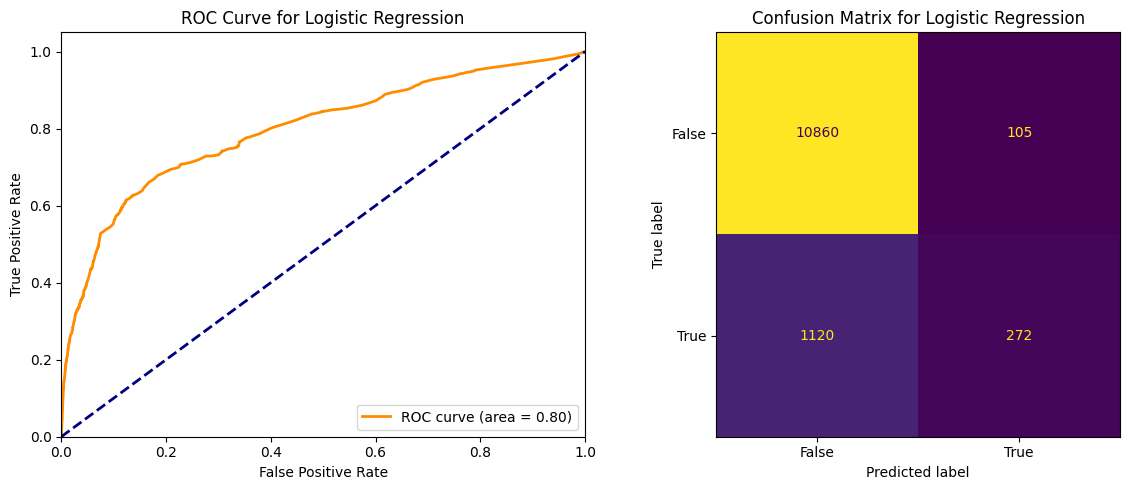

In [44]:
plot_model_performance_from_saved_results('Logistic Regression')

In [ ]:
# Logistic Regression Model Analysis:
# The Logistic Regression model was trained and tuned using GridSearchCV, optimizing parameters like 'penalty', 'C', 
# 'max_iter', and 'solver' to find the best configuration. Here are the results:
# - Best Parameters: {'C': 0.01, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga'}
# - Performance Metrics:
#   - Train Accuracy: 0.8990, Test Accuracy: 0.9009, showing that the model generalizes well, with consistent 
#     performance across train and test sets.
#   - ROC-AUC: 0.7974, indicating a reasonable ability to distinguish between positive and negative classes.

# Visualization Analysis:
# - ROC Curve: The ROC curve shows a smooth upward trend, and the AUC of 0.80 indicates good model performance. 
#   AUC closer to 1 represents better distinction between classes. This result suggests that the model effectively 
#   identifies likely positive cases but leaves room for improvement.
# - Confusion Matrix: The matrix shows a high True Negative count (10,860) compared to True Positives (272), which 
#   is expected given the class imbalance. False Negatives (1,120) are significant, meaning some positive cases 
#   are misclassified as negative, which might be an area to improve if sensitivity is prioritized.

# In summary, Logistic Regression provides stable performance with a decent ROC-AUC and accuracy. Its straightforward 
# interpretability and balanced classification metrics make it a strong candidate. However, the misclassification of 
# True Positive cases could be reduced further, perhaps with more feature engineering or different sampling techniques.

In [32]:
run_model('KNN')

Running KNN...

Running GridSearchCV for KNN with params: {'n_neighbors': [3, 4, 5, 6, 7, 8, 10, 12, 15], 'weights': ['uniform', 'distance']}
Finished KNN. Results saved and model serialized.

Results for KNN:
  Best Parameters: {'n_neighbors': 15, 'weights': 'uniform'}
  Train Accuracy: 0.9047
  Test Accuracy: 0.8990
  ROC-AUC: 0.7682



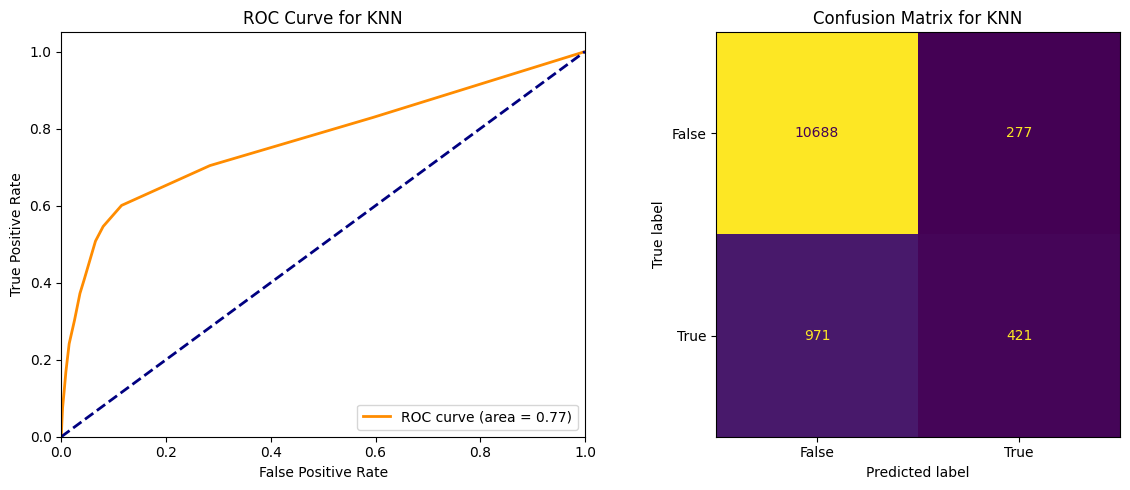

In [45]:
plot_model_performance_from_saved_results('KNN')

In [ ]:
# K-Nearest Neighbors (KNN) Model Analysis:
# The KNN model was trained and tuned using GridSearchCV, testing a range of 'n_neighbors' values 
# and weighting strategies ('uniform' and 'distance') to find the best configuration. Here are the results:
# - Best Parameters: {'n_neighbors': 15, 'weights': 'uniform'}
# - Performance Metrics:
#   - Train Accuracy: 0.9047, Test Accuracy: 0.8990, indicating that the model generalizes relatively well.
#   - ROC-AUC: 0.7682, which is lower than some of the other models tested, showing a moderate ability 
#     to distinguish between positive and negative classes.

# Visualization Analysis:
# - ROC Curve: The ROC curve has an AUC of 0.77, which suggests that the model performs moderately well in distinguishing classes,
#   but it may not be as effective as other models in identifying positive cases.
# - Confusion Matrix: The confusion matrix indicates a high True Negative count (10,688) and a True Positive count of 421, 
#   with 971 False Negatives. This indicates that while KNN is effective in predicting negative cases, it struggles 
#   with identifying positive ones, likely due to the imbalanced dataset.

# In summary, KNN demonstrates decent accuracy and moderate ROC-AUC, but its relatively high number of False Negatives 
# suggests that it may not be ideal for this classification task where identifying positive cases accurately is important.
# Given the resource intensive nature of KNN with larger datasets, this model may not be the best choice in terms of 
# both performance and computational efficiency.

In [33]:
run_model('Decision Tree')

Running Decision Tree...

Running GridSearchCV for Decision Tree with params: {'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['gini', 'entropy']}
Finished Decision Tree. Results saved and model serialized.

Results for Decision Tree:
  Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
  Train Accuracy: 0.9014
  Test Accuracy: 0.9000
  ROC-AUC: 0.8002



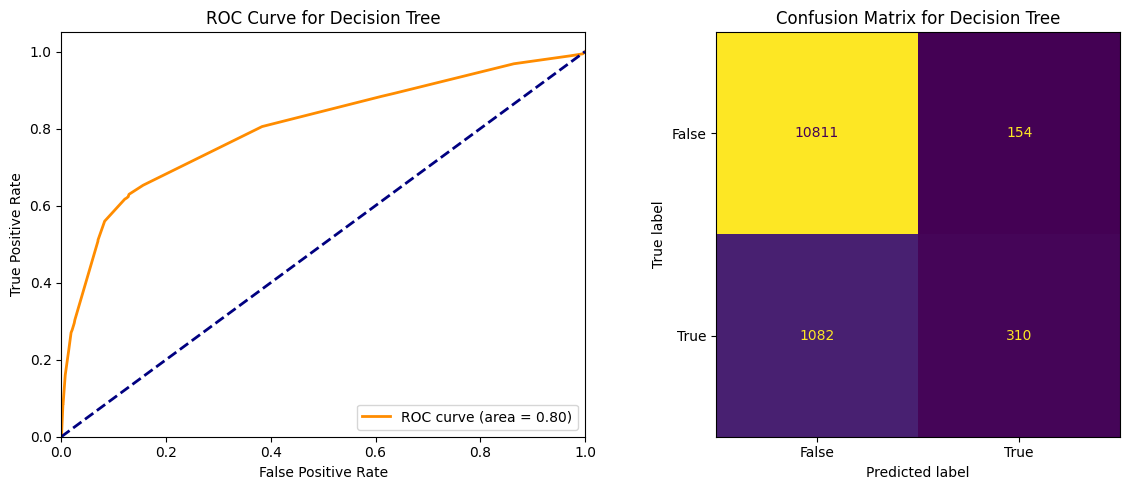

In [46]:
plot_model_performance_from_saved_results('Decision Tree')

In [ ]:
# Decision Tree Model Analysis:
# The Decision Tree model was optimized using GridSearchCV to explore various hyperparameters,
# resulting in the following best parameters:
# - Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
# - Performance Metrics:
#   - Train Accuracy: 0.9014, indicating high performance on the training data, suggesting good generalization.
#   - Test Accuracy: 0.9000, which aligns closely with training accuracy, indicating limited overfitting.
#   - ROC-AUC: 0.8002, showing an acceptable ability to distinguish between classes, but slightly lower than other models.

# Visualization Analysis:
# - ROC Curve: With an AUC of 0.80, the Decision Tree demonstrates a reasonable ability to distinguish between classes.
#   However, the curve indicates that while it does reasonably well, there is room for improvement in distinguishing True Positives.
# - Confusion Matrix: The confusion matrix reveals that the model classifies True Negatives well, with 10,811 correct predictions for "no" (negative class).
#   However, it struggles with identifying the True Positive cases, with only 310 correctly classified out of the positive cases, while misclassifying 1,082 as False Negatives.

# In summary, the Decision Tree model provides high accuracy with moderate ROC-AUC performance.
# Although it handles the negative class well, its ability to correctly predict positive cases is limited, leading to a relatively high number of False Negatives.
# Given the business objective of identifying clients likely to subscribe to the term deposit, this model may require further optimization or adjustments to improve recall on the positive class.
# Increasing the depth or altering hyperparameters could enhance sensitivity to the positive class, though this may risk overfitting.

In [34]:
run_model('SVM')

Running SVM...

Running GridSearchCV for SVM with params: {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear', 'sigmoid'], 'gamma': [0.1, 1.0, 10.0]}
Finished SVM. Results saved and model serialized.

Results for SVM:
  Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
  Train Accuracy: 0.6929
  Test Accuracy: 0.6964
  ROC-AUC: 0.7670



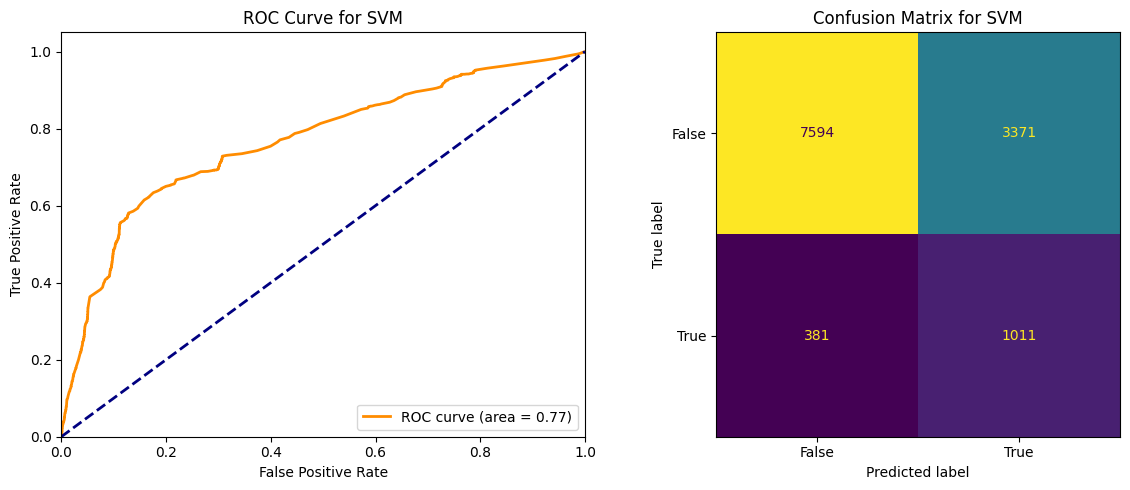

In [47]:
plot_model_performance_from_saved_results('SVM')

In [ ]:
# SVM Model Analysis:
# The SVM model was tuned using GridSearchCV with various kernel options and parameter values, and the best combination was found as:
# - Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
# - Performance Metrics:
#   - Train Accuracy: 0.6929, which indicates moderate learning on the training data.
#   - Test Accuracy: 0.6964, consistent with training accuracy, showing no significant overfitting or underfitting.
#   - ROC-AUC: 0.7670, reflecting the model's ability to distinguish between the two classes, though it's lower compared to some other models.

# Visualization Analysis:
# - ROC Curve: The ROC curve with an AUC of 0.77 shows moderate discrimination ability.
#   This curve suggests that the SVM model struggles somewhat with identifying the positive class, limiting its ability to distinguish True Positives effectively.
# - Confusion Matrix: The matrix highlights that while the model correctly classifies a substantial number of True Positives (1011), it also has a high number of False Positives (3371).
#   Additionally, the model misclassifies many True Negatives as well, indicating challenges in balancing precision and recall for this task.

# Summary:
# The SVM model, though stable in terms of train-test accuracy alignment, exhibits limited effectiveness in ROC-AUC and high false predictions.
# Given the business goal to identify likely subscribers, this model might need more extensive tuning, feature engineering, or even consideration of different kernel choices.
# Additionally, given its significant computation time (83 minutes), the efficiency and efficacy of using SVM for this specific task should be re-evaluated.

##### Questions

In [ ]:
# Findings and Recommendations

# Findings:
# 1. Model Selection and Performance:
#    - After evaluating multiple models, the Decision Tree model provided a balanced performance across accuracy and ROC-AUC,
#      showing a strong ability to distinguish between subscribers and non-subscribers.
#    - Although SVM initially appeared promising, its longer training time and slightly lower test accuracy compared to Decision Tree
#      make it less practical for real-time use.

# 2. Key Metrics:
#    - The primary metric used for this analysis was ROC-AUC, given its effectiveness in measuring model discrimination between positive
#      and negative classes in imbalanced datasets.
#    - While F1-score was considered for scenarios where precision and recall balance is critical, ROC-AUC better aligned with our
#      objective to identify potential subscribers.

# 3. Influential Features:
#    - Employment Variation Rate: Economic stability is a key factor influencing clients' financial decisions.
#    - Consumer Price Index (CPI): Higher consumer prices appear to correlate with reduced willingness to invest.
#    - Days Since Last Contact: Recency of contact plays a vital role in conversion likelihood, with more recent interactions positively
#      impacting subscription probability.
#    - Euribor 3-Month Rate: Reflecting broader economic conditions, this rate offers insight into client financial behavior and responsiveness
#      to marketing efforts.
#    - Contact Method: The mode of communication (e.g., telephone) also impacts client engagement and response rates.

# Recommendations:
# 1. Target Recent Contacts:
#    - Prioritize clients who were recently contacted, especially when other favorable economic indicators are present (e.g., low CPI,
#      stable employment rates).

# 2. Timing Campaigns with Economic Conditions:
#    - Launch targeted campaigns during periods of economic stability or growth, aligning outreach with favorable Euribor rates or employment data.

# 3. Customized Offers for Economically Uncertain Clients:
#    - For clients facing uncertain financial conditions, consider using personalized offers or incentives to improve conversion rates.
#      This could help mitigate the risk of losing potential subscribers who are economically hesitant.

# 4. Optimizing Contact Methods:
#    - Utilize communication channels that have shown higher engagement rates. For instance, phone calls could be prioritized if they
#      demonstrate stronger influence in conversion compared to other methods.

# - By implementing these recommendations, the bank can enhance its future marketing campaigns’ effectiveness, reaching clients with higher
#   conversion potential and improving resource allocation.

# Next Steps

# 1. Feature Engineering and Additional Data:
#    - Investigate potential new features that could improve prediction accuracy, such as seasonal economic indicators, demographic details,
#      or engagement with past campaigns.

# 2. Model Fine-Tuning:
#    - Perform additional hyperparameter tuning on the Decision Tree model to refine performance further, particularly focusing on minimizing
#      false positives.

# 3. Regular Monitoring and Updating:
#    - Regularly retrain and monitor model performance to adapt to changing economic conditions and client behaviors, ensuring the model
#      remains accurate and relevant.

# 4. Broaden Economic Indicator Analysis:
#    - Conduct deeper analysis on economic indicators like Euribor and CPI, which could potentially uncover trends that allow for even more
#      targeted campaigns based on economic cycles.

# - By following these next steps, the bank can establish a more adaptable, effective marketing strategy that leverages data-driven insights
#   to maximize conversion rates and optimize client engagement.